# LOAD LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import math
import json
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
from scipy.stats import linregress

# CONFIGURATION

In [2]:
START_DATE, END_DATE = '2022-09-01', '2023-10-05'
TIME_RESOLUTION = '4'
TARGET_FLUX = 'n2o'
QUALITY_FLAG = 'qcf0'
N_FOLDS = 10
MODEL_TYPE = 'XGBoost'  # Options: 'RandomForest' or 'XGBoost'
CROSSVAL_SPLIT = 'time_blocks_eliza' # options: 'custom_time_blocks' or 'kfold' or 'time_blocks_eliza'
LOG_TRANSFORM = False
UNDERSAMPLE = False

# LOAD DATA

In [3]:
data_main = pd.read_csv(f'../data/processed/DRIVERS_dataset_{TIME_RESOLUTION}h.csv', low_memory=False)
data_main['timestamp_middle'] = pd.to_datetime(data_main['timestamp_middle'])
data_main.set_index('timestamp_middle', inplace=True)
data_main = data_main.loc[START_DATE:END_DATE]

# Add an id column to account for the proximity of values as the timestamp is continuous without gaps
data_main['id'] = range(0, len(data_main))

In [4]:
TARGET = f'flux_{TARGET_FLUX}_{QUALITY_FLAG}'

median_nan_size = (
    data_main[TARGET]
    .isna()
    .ne(data_main[TARGET].isna().shift())
    .cumsum()
    .where(data_main[TARGET].isna())
    .dropna()
    .value_counts()
    .median()
)
print("Median size of consecutive NaNs in the target variable:", median_nan_size)

Median size of consecutive NaNs in the target variable: 3.0


# SELECT FEATURES

In [5]:
# Import the best features
# path = '../data/processed/best_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
# with open(path, 'r') as f:
#     selected_features = [line.strip() for line in f]

# Other option is to define the best n features
# n_top = 5
# path = '../data/processed/ranked_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
# with open(path, 'r') as f:
#     selected_features = [line.strip() for line in f][:n_top]


# Selection based on 'ranked_features' and picking the most important features from each of the driver categories
selected_features = [
'n_decay_timed',
'timesince_fert', 
'timesince_soil_preparation',
'wfps_0.3_roll48hmean',
'wfps_0.3_diff48h',
'ts_0.3_roll48hmean',
'flux_gpp_roll48hsum'
]

# Keep only the best feature set
data = data_main[selected_features + [TARGET]].copy()
# Remove NAs
data = data[data[TARGET].notna()]

data

,n_decay_timed,timesince_fert,timesince_soil_preparation,wfps_0.3_roll48hmean,wfps_0.3_diff48h,ts_0.3_roll48hmean,flux_gpp_roll48hsum,flux_n2o_qcf0
timestamp_middle,,,,,,,,
2022-09-01 04:00:00,0.0,30,30,31.006986,-0.231051,19.504965,72.318492,0.242429
2022-09-01 08:00:00,0.0,30,30,30.985383,-0.259238,19.468605,71.271602,-0.020742
2022-09-01 12:00:00,0.0,30,30,30.964550,-0.249998,19.420058,77.264540,-0.233794
2022-09-01 16:00:00,0.0,30,30,30.941929,-0.271450,19.353177,80.504853,-0.255840
2022-09-02 08:00:00,0.0,30,30,30.936376,-0.083852,18.991678,94.061389,-0.265809
...,...,...,...,...,...,...,...,...
2023-10-03 20:00:00,0.0,30,7,53.457668,-0.554744,15.991667,12.512343,0.904912
2023-10-04 08:00:00,0.0,30,7,53.330581,-0.505746,16.009387,9.217772,0.781407
2023-10-04 12:00:00,0.0,30,7,53.283957,-0.559491,16.016933,7.554424,1.360674


# SELECT MODEL

In [6]:
# Load hyperparameters from JSON file
path = '../data/processed/best_hyperparameters_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.json'
with open(path, "r") as file:
    hyperparams = json.load(file)

# Print loaded hyperparameters (optional)
print("Loaded Hyperparameters:", hyperparams)

model = RandomForestRegressor(**hyperparams, random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric="rmse") if MODEL_TYPE == 'RandomForest' else XGBRegressor(**hyperparams, random_state=42, n_jobs=-1)

Loaded Hyperparameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.65}


# IMBALANCE HANDLING

## UNDER SAMPLING

In [7]:
if UNDERSAMPLE:
    quantile_cutoff = 0.8
    cutoff_value = data[TARGET].quantile(quantile_cutoff)
    print(f'Undersampling target data below: {cutoff_value}')
    # Split and undersample
    upper = data[data[TARGET] > cutoff_value]
    lower = data[data[TARGET] <= cutoff_value]
    # Undersample
    lower_sampled = lower.sample(frac=0.5, random_state=42)
    # Combine
    data = pd.concat([upper, lower_sampled]).sample(frac=1, random_state=42)
    # Resort data
    data = data.sort_index().reset_index(drop=False)  # keep the timestamp as a column
    data = data.set_index('timestamp_middle')    # and set it back as index if needed
    # Plot
    data[TARGET].plot(x_compat=True, style='.');

## LOG TRANSFORMATION

In [8]:
min_value = data[TARGET].min()

def log_transform(x):
    return np.log1p(x - min_value) if min_value < 0 else np.log1p(x)

def inverse_log_transform(x):
    return np.expm1(x) + min_value if min_value < 0 else np.expm1(x)

if LOG_TRANSFORM:
    data[TARGET] = log_transform(data[TARGET])
    print('The target was log transformed')
    # Show histogram of TARGET
    plt.hist(data[TARGET], bins=20)
    plt.xlabel(TARGET)
    plt.show()
    # Show timeseries
    data[TARGET].plot(x_compat=True, style='.');

# CROSS-VAL SPLITS

Using stratified approach based on the target variable

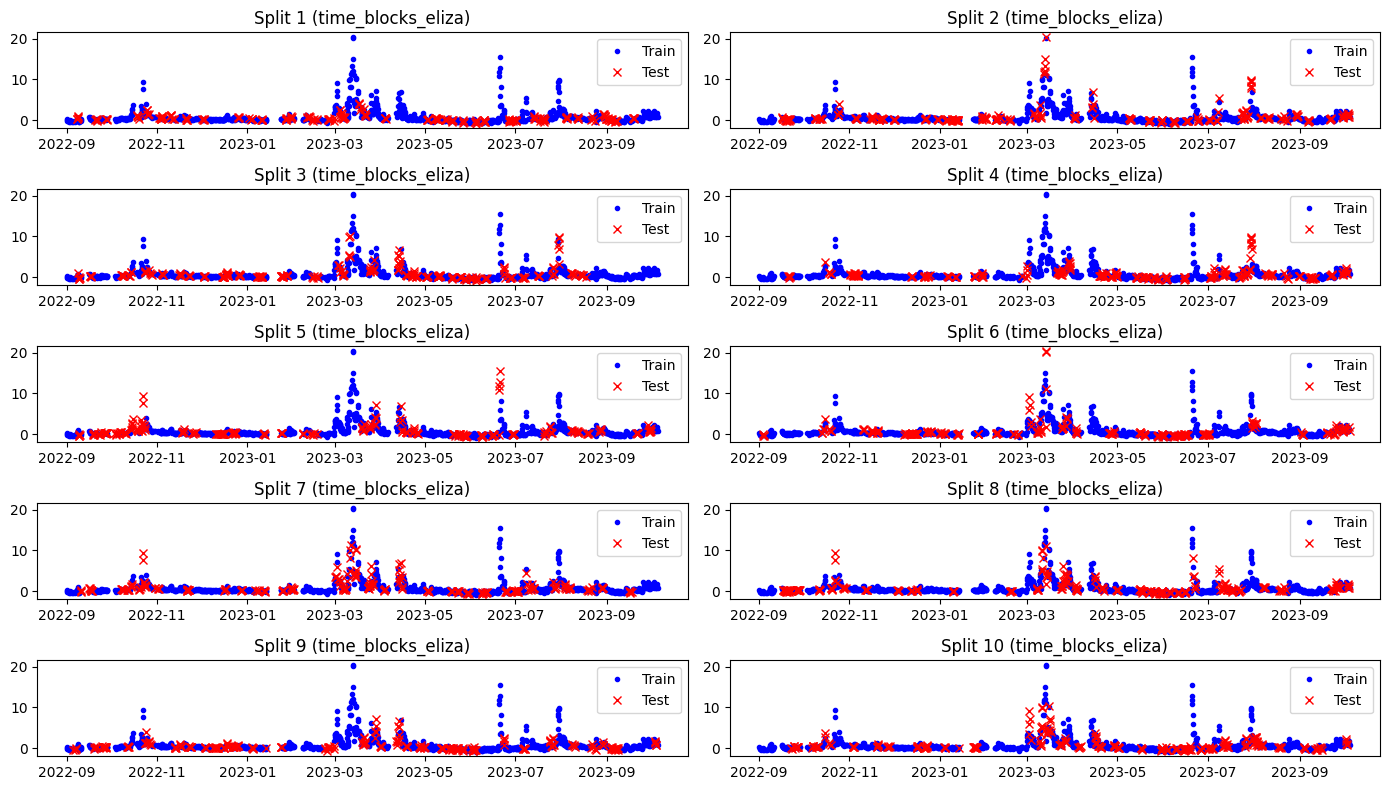

In [9]:
def create_splits(X, y, n_folds, test_size=0.2, random_state=42, n_bins=5):
    """Creates train-test splits using StratifiedShuffleSplit or StratifiedKFold with equal-width binning."""
    
    # Use pd.cut to create equal-width bins (avoids empty bins issue)
    y_binned = pd.cut(y, bins=n_bins, labels=False, include_lowest=True)

    # Select method for stratified splitting
    if CROSSVAL_SPLIT == "shuffle":
        splitter = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=random_state)
    elif CROSSVAL_SPLIT == "kfold":
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=False)

    # Generate train-test splits
    splits = [(train_idx, test_idx) for train_idx, test_idx in splitter.split(X, y_binned)]

    return splits

if CROSSVAL_SPLIT == 'time_blocks_eliza':
    def create_splits(X, y, n_folds, split=0.2, mean_block = 5, min_block=3, random_state=42): # you can set mean block to median_nan_size
        """Generates multiple train-test index splits using block-based cross-validation by varying the random seed."""
        splits = []
        total_test = round(len(X) * split)
        n_blocks = round(total_test/mean_block)

        if mean_block < min_block:
            raise ValueError("Min block size is too large for the number of blocks.")

        for fold in range(n_folds):
            np.random.seed(random_state + fold)  # Change seed for each fold
            
            tt = np.zeros(len(X))  # Array to store train-test assignments

            # Generate random block sizes with normal variation
            blocks = np.array([max(min_block, mean_block + round(v)) 
                            for v in np.random.normal(0, mean_block / 10, n_blocks)])

            # Randomly shuffle the starting positions of test blocks
            available_positions = np.arange(len(X))  # Possible start positions
            np.random.shuffle(available_positions)   # Shuffle them

            # Assign blocks sequentially based on shuffled positions
            assigned = set()
            for b in blocks:
                if len(assigned) >= total_test:
                    break
                # Pick a random starting position
                istart = np.random.choice(available_positions)
                iend = min(istart + int(b), len(X))

                # Ensure blocks don't overlap significantly
                assigned.update(range(istart, iend))
                tt[istart:iend] = 1

            train_idx = np.where(tt == 0)[0]
            test_idx = np.where(tt == 1)[0]
            
            splits.append((train_idx, test_idx))

        return splits


X = data.drop(columns=TARGET)
y = data[TARGET]
# Create the splits using StratifiedShuffleSplit
cross_val_splits = create_splits(X, y, n_folds=N_FOLDS)


# --- PLOT TRAIN-TEST SPLITS ---
n_rows = math.ceil(N_FOLDS / 2)  # Ensure enough rows for all splits
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 8))
axes = axes.flatten()  # Flatten the axes array to make iteration easier

for i, (train_idx, test_idx) in enumerate(cross_val_splits):
    train_idx_mapped = X.iloc[train_idx].index
    test_idx_mapped = X.iloc[test_idx].index

    # Plot train and test points
    axes[i].plot(y.loc[train_idx_mapped].index, y.loc[train_idx_mapped], '.', label='Train', color="blue")
    axes[i].plot(y.loc[test_idx_mapped].index, y.loc[test_idx_mapped], 'x', label='Test', color="red")
    
    axes[i].set_title(f"Split {i + 1} ({CROSSVAL_SPLIT})")
    axes[i].legend()

# Hide unused subplots if n_folds is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# CROSS-VALIDATION

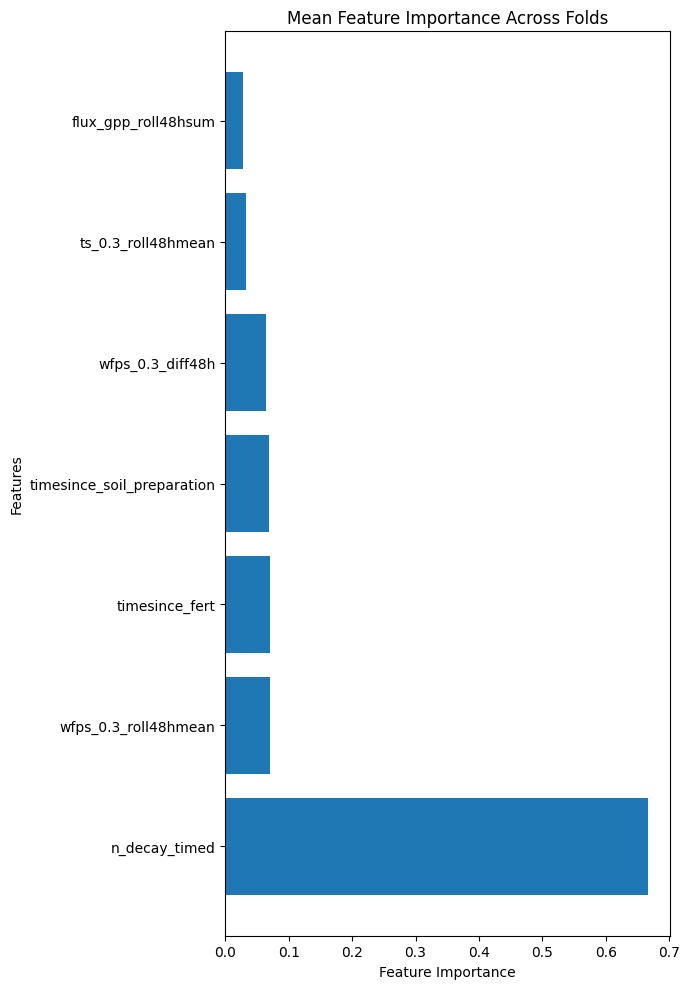

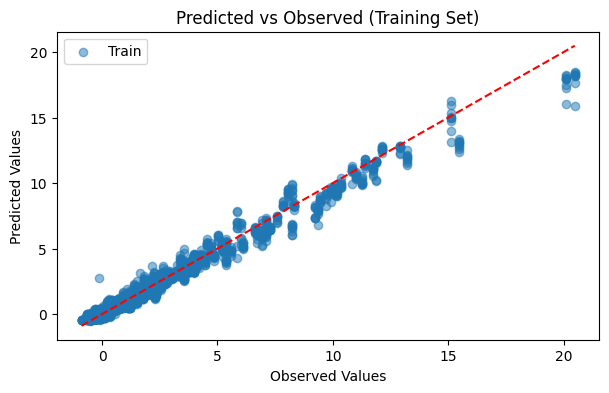

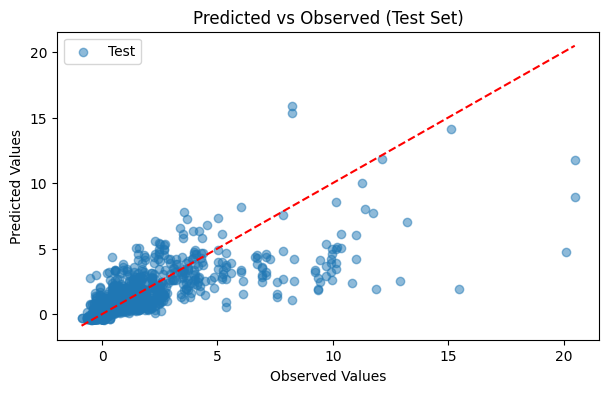

Train RMSE per fold: [0.2847 0.2997 0.2696 0.3153 0.249  0.2505 0.2627 0.2738 0.2708 0.2888]
Mean Train RMSE: 0.2765
Test RMSE per fold: [0.5382 1.1969 1.0219 1.1314 1.6509 1.6069 1.2018 1.3401 0.6067 1.1306]
Mean Test RMSE: 1.1426
Train R² per fold: [0.9815 0.9707 0.9815 0.9756 0.9832 0.9817 0.9812 0.9804 0.9829 0.9785]
Mean Train R²: 0.9797
Test R² per fold: [0.4434 0.7828 0.6426 0.4297 0.3162 0.4956 0.6383 0.4707 0.6988 0.5903]
Mean Test R²: 0.5508


In [10]:
X = data.drop(columns=TARGET)
y = data[TARGET]

# Store results
rmse_train_values, rmse_test_values = [], []
r2_train_values, r2_test_values = [], []
feature_importances_folds = []
y_train_all, y_train_pred_all = [], []
y_test_all, y_pred_test_all = [], []

# Perform cross-validation
for train_idx, test_idx in cross_val_splits:  
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    if LOG_TRANSFORM:
        y_train =  inverse_log_transform(y_train)
        y_test =  inverse_log_transform(y_test)
        y_train_pred =  inverse_log_transform(y_train_pred)
        y_test_pred =  inverse_log_transform(y_test_pred)

    # Store RMSE & R² for training and test sets
    rmse_train_values.append(root_mean_squared_error(y_train, y_train_pred))
    rmse_test_values.append(root_mean_squared_error(y_test, y_test_pred))
    r2_train_values.append(r2_score(y_train, y_train_pred))
    r2_test_values.append(r2_score(y_test, y_test_pred))

    # Store feature importances
    feature_importances_folds.append(model.feature_importances_)

    # Store predictions
    y_train_all.extend(y_train)
    y_train_pred_all.extend(y_train_pred)
    y_test_all.extend(y_test)
    y_pred_test_all.extend(y_test_pred)

# Compute mean feature importance across folds
feature_importances = np.nanmean(feature_importances_folds, axis=0)
# Sort feature importances
order = np.argsort(-feature_importances)  # Sort in descending order
feature_names = X_train.columns[order]  # Get feature names sorted by importance

# Plot sorted feature importances
fig, ax = plt.subplots(figsize=(7, 10))
ax.barh(feature_names, feature_importances[order])
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
ax.set_title("Mean Feature Importance Across Folds")
fig.tight_layout()
plt.show()

# Plot Predicted vs Observed (Training Set)
plt.figure(figsize=(7, 4))
plt.scatter(y_train_all, y_train_pred_all, alpha=0.5, label="Train")
plt.plot([min(y_train_all), max(y_train_all)], [min(y_train_all), max(y_train_all)], color='red', linestyle='--')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Observed (Training Set)")
plt.legend()
plt.show()

# Plot Predicted vs Observed (Test Set)
plt.figure(figsize=(7, 4))
plt.scatter(y_test_all, y_pred_test_all, alpha=0.5, label="Test")
plt.plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], color='red', linestyle='--')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Observed (Test Set)")
plt.legend()
plt.show()

# Print RMSE and R² for both Training and Test sets
print(f"Train RMSE per fold: {np.array(rmse_train_values).round(4)}")
print(f"Mean Train RMSE: {np.mean(rmse_train_values):.4f}")
print(f"Test RMSE per fold: {np.array(rmse_test_values).round(4)}")
print(f"Mean Test RMSE: {np.mean(rmse_test_values):.4f}")

print(f"Train R² per fold: {np.array(r2_train_values).round(4)}")
print(f"Mean Train R²: {np.mean(r2_train_values):.4f}")
print(f"Test R² per fold: {np.array(r2_test_values).round(4)}")
print(f"Mean Test R²: {np.mean(r2_test_values):.4f}")


# FINAL MODEL

## Split train-test

Block splitting with test blocks that can vary of size and we can define the minimum size

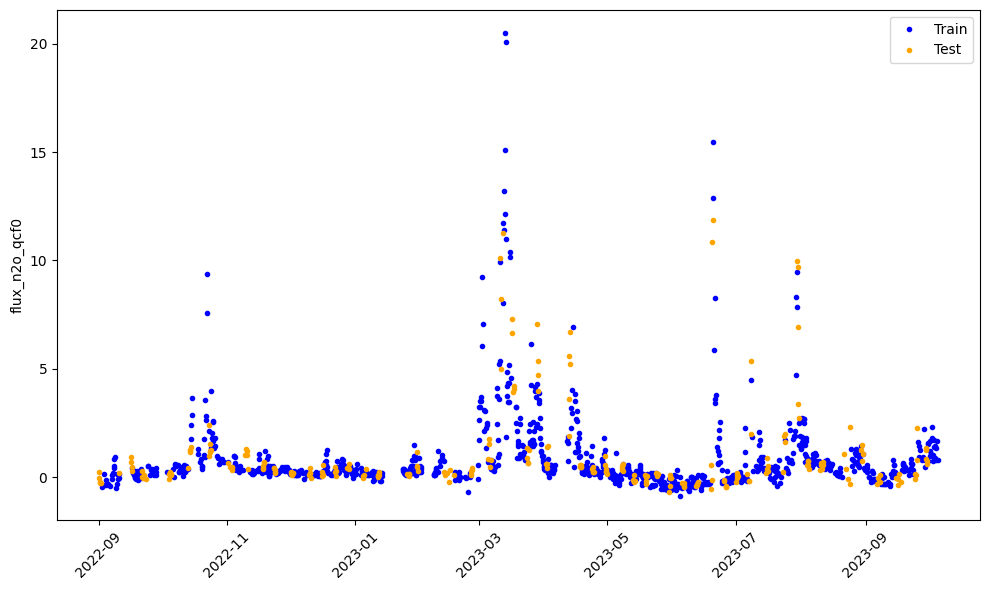

In [11]:
mean_block = 5

def split_blocks(X, y, mean_block = mean_block, split=0.2, min_block=3):
       np.random.seed(42)  # Set seed for reproducibility
       tt = np.zeros(len(X)) # space for training/test assignments
       total_test = round(len(X)* split)
       n_blocks = round(total_test/mean_block)
       if mean_block<min_block:
              print("Error: Min block too long for this many blocks")
              return None
       # Vary the length of blocks around the mean (but not below the min)
       blocks = np.array([mean_block + round(v) for v in np.random.normal(0, mean_block/10, n_blocks)])
       blocks[blocks < min_block] = min_block
       # Assign the blocks
       for n, b in enumerate(blocks):
              istart = round(len(X)/(n_blocks))*(n-1)
              iend = istart+b
              tt[istart:iend] = 1
       X_train = X[tt==0]
       X_test = X[tt==1]
       y_train = y[tt==0]
       y_test = y[tt==1]
       # Return sorted data by index (timestamp)
       return X_train.sort_index(), X_test.sort_index(), y_train.sort_index(), y_test.sort_index(), tt

X = data.drop(columns=TARGET)
y = data[TARGET]
X_train, X_test, y_train, y_test, tt = split_blocks(X, y, mean_block=mean_block) # set number of blocks
              
# Check the split
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted size for better readability
ax.plot(y_train.index, y_train, ".", label="Train", color='blue')
ax.plot(y_test.index, y_test, ".", label="Test", color='orange')
ax.set_ylabel(TARGET)
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()

# Show the plot
plt.show()

## Model training and testing

[0]	validation_0-rmse:2.02620
[1]	validation_0-rmse:1.97203
[2]	validation_0-rmse:1.91757
[3]	validation_0-rmse:1.88184
[4]	validation_0-rmse:1.84480
[5]	validation_0-rmse:1.80034
[6]	validation_0-rmse:1.75677
[7]	validation_0-rmse:1.72298
[8]	validation_0-rmse:1.69745
[9]	validation_0-rmse:1.66764
[10]	validation_0-rmse:1.64294
[11]	validation_0-rmse:1.61282
[12]	validation_0-rmse:1.57906
[13]	validation_0-rmse:1.55747
[14]	validation_0-rmse:1.53033
[15]	validation_0-rmse:1.51004
[16]	validation_0-rmse:1.49597
[17]	validation_0-rmse:1.47017
[18]	validation_0-rmse:1.44170
[19]	validation_0-rmse:1.42710
[20]	validation_0-rmse:1.41428
[21]	validation_0-rmse:1.39555
[22]	validation_0-rmse:1.38412
[23]	validation_0-rmse:1.37201
[24]	validation_0-rmse:1.35361
[25]	validation_0-rmse:1.33740
[26]	validation_0-rmse:1.31960
[27]	validation_0-rmse:1.30892
[28]	validation_0-rmse:1.30252
[29]	validation_0-rmse:1.28808
[30]	validation_0-rmse:1.28539
[31]	validation_0-rmse:1.27365
[32]	validation_0-

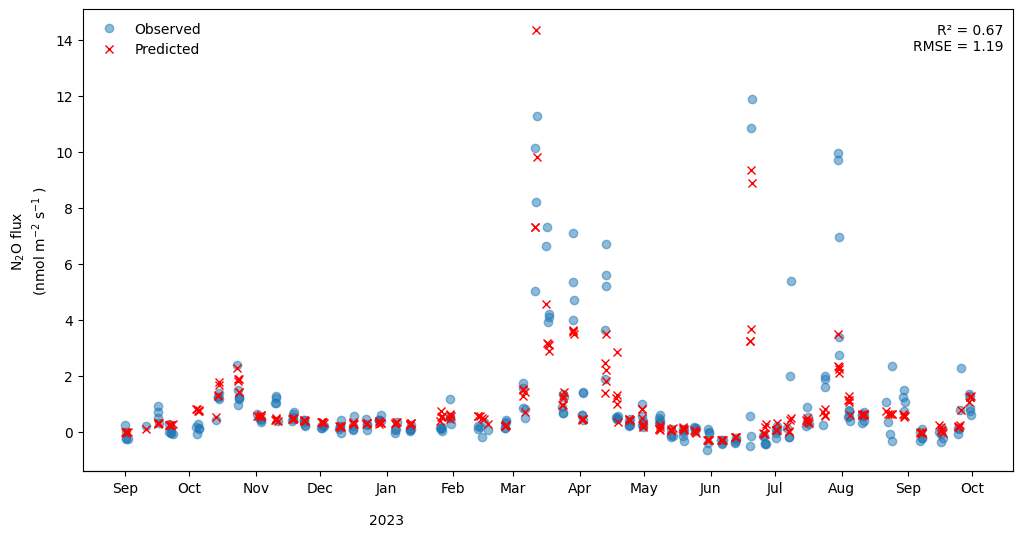

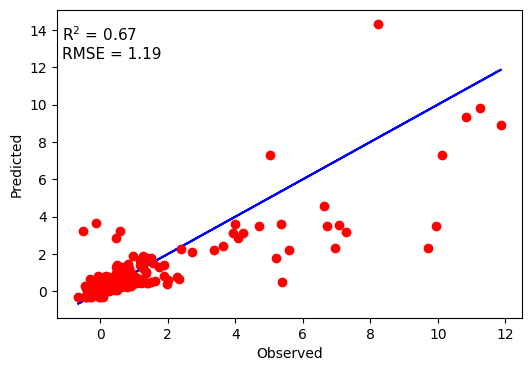

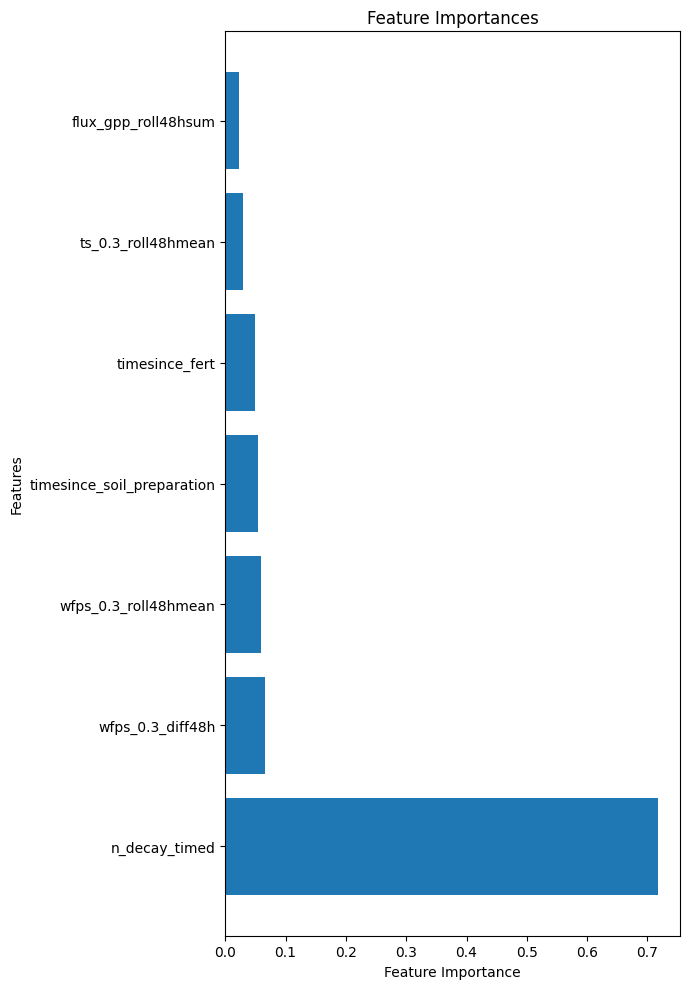

In [12]:
# Use early stopping if using XGBoost
model = RandomForestRegressor(**hyperparams, random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric="rmse") if MODEL_TYPE == 'RandomForest' else XGBRegressor(**hyperparams, random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric="rmse")

# Predict test set
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Reverse the log transformation on the predictions and the original transformed data when the transformation was used
if LOG_TRANSFORM:
    pred_train = inverse_log_transform(pred_train) 
    pred_test = inverse_log_transform(pred_test)
    y_train = inverse_log_transform(y_train)
    y_test = inverse_log_transform(y_test)

# Calculate R-squared and Mean Squared Error (MSE) for the training set
r2_train = r2_score(y_train, pred_train)
print(f"R-squared (Training set): {r2_train:.4f}")
rmse_train = root_mean_squared_error(y_train, pred_train)
print(f"Root Mean Squared Error (Training set): {rmse_train:.4f}")
# Calculate R-squared and Mean Squared Error (MSE) for the test set
r2_test = r2_score(y_test, pred_test)
print(f"R-squared (Test set): {r2_test:.4f}")
rmse_test = root_mean_squared_error(y_test, pred_test)
print(f"Root Mean Squared Error (Test set): {rmse_test:.4f}")

# Time series plot
fig, ax = plt.subplots(1,figsize=(12, 6))
ax.plot(y_test.index, y_test,"o",label=("Observed"), alpha=0.5)
ax.plot(y_test.index, pred_test,"rx",label=("Predicted"))
# Format x-axis for months
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks for months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as month abbreviation
# Add secondary x-axis for years
secax = ax.secondary_xaxis('bottom')
secax.xaxis.set_major_locator(mdates.YearLocator())  # Year ticks
secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
secax.tick_params(axis='x', length=0, pad=30)  # Add padding for better readability
# Add R2 and RMSE text
ax.text(0.99, 0.97, f'R² = {r2_test:.2f}\nRMSE = {rmse_test:.2f}',
        transform=ax.transAxes, va='top', ha='right')
ax.set_ylabel('N$_2$O flux\n(nmol m$^{-2}$ s$^{-1}$ )')
ax.legend(frameon=False, loc="upper left")
# save fig
plt.savefig('../figures/model_performance_test.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Obs Vs predicted
fig, ax = plt.subplots(1,figsize=(6,4))
ax.plot(y_test,y_test,"b-")
ax.plot(y_test,pred_test,"ro")
# Add R2 and RMSE text
ax.text(0.01, 0.95, f'R$^{2}$ = {r2_test:.2f}\nRMSE = {rmse_test:.2f}',
        transform=ax.transAxes, va='top', fontsize=11)
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted")
plt.show()

# Plot feature importances
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]  # Sort descending
feature_names_sorted = X_train.columns[sorted_idx]

fig, ax = plt.subplots(figsize=(7, 10))
ax.barh(feature_names_sorted, importances[sorted_idx])
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
ax.set_title("Feature Importances")
plt.tight_layout()
plt.show()

# SHAP ANALYSIS

## RUN SHAP

In [13]:
# define background dataset as undisturbed conditions (fertilization and soil preparation >= 30 days)
cols = [
    'timesince_soil_preparation', 
    'timesince_fert'
    ]
background_dataset = data_main.loc[data_main[cols].eq(30).all(axis=1), selected_features]
#background_dataset = data_main[selected_features]

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model, data=background_dataset)

# Calculate SHAP values for the entire dataset
X = data_main[selected_features]
shap_values = explainer(X, check_additivity=True)

# Print the expected value
print("Baseline (expected value):", explainer.expected_value)
if LOG_TRANSFORM:
    print("Baseline without transformation (expected value):", inverse_log_transform(explainer.expected_value))

 97%|=================== | 2328/2398 [00:14<00:00]       

Baseline (expected value): 0.31027418787595257


## SUMMARY PLOT

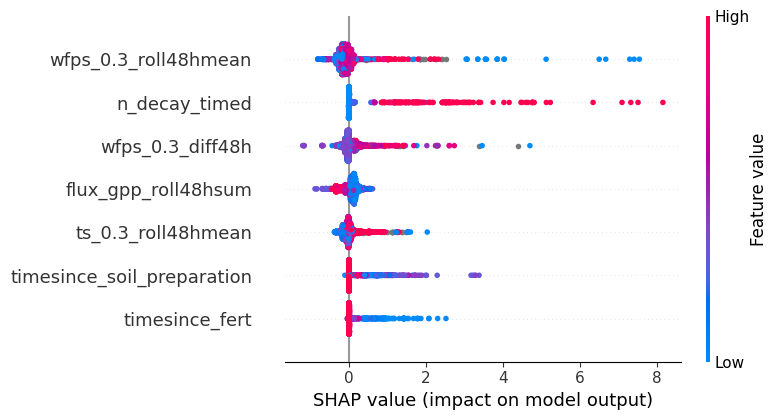

In [14]:
# SHAP summary plot
fig = plt.figure()
shap.summary_plot(shap_values, X, show=False)
# Save the figure
fig.savefig('../figures/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## Restructure dataframe

In [15]:
# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(
    data=shap_values.values,  # SHAP values
    index=X.index,  # Use the index of X
    columns=X.columns  # Use feature names as columns
)

# Pool together fertilization variables
fertilization_cols = [col for col in shap_df.columns if col.startswith('n_decay') or 'fert' in col]
shap_df['fertilization'] = shap_df[fertilization_cols].sum(axis=1)
shap_df.drop(columns=fertilization_cols, inplace=True)

# Pool together WFPS variables
wfps_cols = [col for col in shap_df.columns if col.startswith('wfps')]
shap_df['wfps'] = shap_df[wfps_cols].sum(axis=1)
shap_df.drop(columns=wfps_cols, inplace=True)

# Rename DataFrame columns
rename_dict = {
    next(c for c in shap_df.columns if 'fertilization' in c): 'N fertilization',
    next(c for c in shap_df.columns if 'gpp' in c): 'GPP',
    next(c for c in shap_df.columns if 'wfps' in c): 'WFPS',
    next(c for c in shap_df.columns if 'timesince_soil_preparation' in c): 'Soil disturbance',
    next(c for c in shap_df.columns if 'ts' in c): 'Soil T',
}

# Identify columns to keep and others to aggregate
key_cols = list(rename_dict.keys())
other_cols = [col for col in shap_df.columns if col not in key_cols]
# Rename key columns
shap_df.rename(columns=rename_dict, inplace=True)
# Arbitrary column order
col_order = ['N fertilization', 'WFPS', 'GPP', 'Soil disturbance', 'Soil T']
shap_df = shap_df[col_order]

## Normalization and aggregation

In [16]:
# Create a normalized version of shap values
shap_df_norm = shap_df.div(
    shap_df.abs().sum(axis=1), axis=0
)

# Aggregate SHAP values 
aggregation_period = 'D'
shap_df_agg = shap_df.resample(aggregation_period).mean()
shap_df_agg_norm = shap_df_agg.div(
    shap_df_agg.abs().sum(axis=1), axis=0
)

shap_df_agg_norm

,N fertilization,WFPS,GPP,Soil disturbance,Soil T
timestamp_middle,,,,,
2022-09-01,0.000000,-0.838506,0.116763,0.000000,0.044731
2022-09-02,0.000000,-0.672345,0.132294,0.000000,-0.195361
2022-09-03,0.000000,-0.603789,0.143331,0.000000,-0.252880
2022-09-04,0.000000,-0.562597,0.146548,0.000000,-0.290855
2022-09-05,0.000000,-0.355079,0.045597,0.000000,-0.599324
...,...,...,...,...,...
2023-10-01,0.000000,-0.129473,0.203769,0.584363,0.082395
2023-10-02,0.000000,-0.132571,0.201941,0.556101,0.109387
2023-10-03,0.000000,-0.183874,0.188510,0.529474,0.098142


## TIME-SERIES PLOTS

### Stacked bar plot

Plotting configs

In [17]:
# Define the shading time window
highlight_start = pd.Timestamp('2022-10-06')
highlight_end = pd.Timestamp('2023-07-15')

# Define labels and colors for the management events
event_lines = [
    {'date': '2022-10-06', 'color': '#003366', 'linestyle': ':', 'label': 'sowing'},
    {'date': '2023-07-15', 'color': '#003366', 'linestyle': '--', 'label': 'harvest'}, # wheat harvest
    {'date': '2023-02-26', 'color': '#F2C744', 'linestyle': '-', 'label': None},
    {'date': '2023-02-28', 'color': '#F2C744', 'linestyle': '-', 'label': 'N fert'},
    {'date': '2023-04-06', 'color': '#F2C744', 'linestyle': '-', 'label': 'N fert'},  # second mineral fert
]

# Improved color-blind–friendly palette
palette = [
    '#882255',
    '#0072B2', 
    '#009E73',  
    '#A6761D',  
    '#FDAE61'   
]

Prep input data

In [18]:
# Measured FN2O
fn2o_agg = data_main[TARGET].resample(aggregation_period).mean()

# Predicted FN2O
preds = model.predict(X)
fn2o_preds = pd.Series(preds, index=shap_df.index)
if LOG_TRANSFORM:
    fn2o_preds = inverse_log_transform(fn2o_preds)
fn2o_preds_agg = fn2o_preds.resample(aggregation_period).mean()

# Daily GPP
gpp_agg = data_main['flux_gpp'].resample(aggregation_period).mean()

#### plotting functions

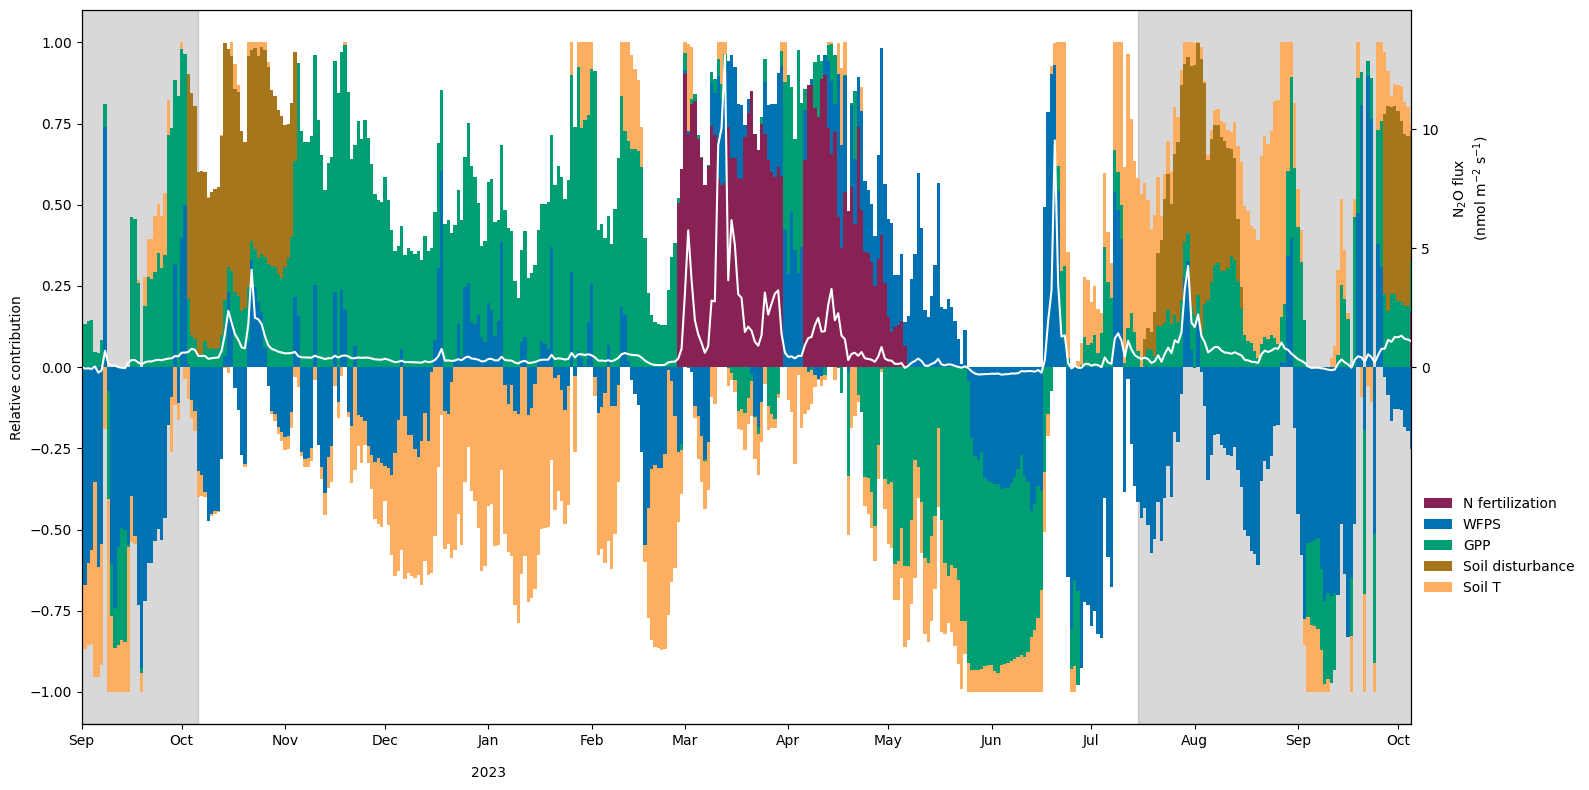

In [19]:
def plot_shap_timeseries(df, shading=True, fn2o_observed=None, fn2o_predicted=None, width=1, start_date=None, end_date=None, ax1=None, ax2=None):

    # Filter data if date range is provided
    if start_date or end_date:
        df = df.loc[start_date:end_date]
        if fn2o_observed is not None:
            fn2o_observed = fn2o_observed.loc[start_date:end_date]
        if fn2o_predicted is not None:
            fn2o_predicted = fn2o_predicted.loc[start_date:end_date]

    # Split SHAP values into positive and negative contributions
    shap_df_pos = df.clip(lower=0)
    shap_df_neg = df.clip(upper=0)

    # Plot SHAP positive contributions
    bottom_pos = None
    for idx, column in enumerate(shap_df_pos.columns):
        ax1.bar(
            shap_df_pos.index,
            shap_df_pos[column],
            bottom=bottom_pos,
            label=column,
            color=palette[idx],
           width=width
        )
        bottom_pos = shap_df_pos[column] if bottom_pos is None else bottom_pos + shap_df_pos[column]

    # Plot SHAP negative contributions
    bottom_neg = None
    for idx, column in enumerate(shap_df_neg.columns):
        ax1.bar(
            shap_df_neg.index,
            shap_df_neg[column],
            bottom=bottom_neg,
            label=None,
            color=palette[idx],
            width=width
        )
        bottom_neg = shap_df_neg[column] if bottom_neg is None else bottom_neg + shap_df_neg[column]

    # Add shading to highlight a certain time window
    if shading:
        ax1.axvspan('2022-09-01', highlight_start, color='gray', alpha=0.3, zorder=0)
        ax1.axvspan(highlight_end, df.index.max(), color='gray', alpha=0.3, zorder=0)

    # Secondary y-axis for fn2o
    ax2 = None
    if fn2o_observed is not None or fn2o_predicted is not None:
        ax2 = ax1.twinx()
    if fn2o_observed is not None:
        ax2.plot(fn2o_observed.index, fn2o_observed, color='white', marker='x', linestyle='none',
                alpha=1, linewidth=1.5, label='measured N$_2$O flux')
    if fn2o_predicted is not None:
        ax2.plot(fn2o_predicted.index, fn2o_predicted, color='white', linestyle='-',
                alpha=1, linewidth=1.5,
#                label='predicted N$_2$O flux'
                )

    # Format y axis
    ax1.set_ylim(-1.1, 1.1)
    if ax2 is not None:
        y2_max = 15
        ax2.set_ylim(-y2_max, y2_max)
        ax2.set_yticks([tick for tick in ax2.get_yticks() if tick >= 0 and tick <= 10])
    
    # Labels and legends
    ax1.set_ylabel("Relative contribution")
    if ax2 is not None:    
        ax2.set_ylabel("N$_2$O flux\n(nmol m$^{-2}$ s$^{-1}$)")
        ax2.yaxis.set_label_coords(1.03, 0.75)  # set new vertical (y) position
    ax1.legend(bbox_to_anchor=(1, 0.25), frameon=False, loc="center left")

    # Format x-axis for months
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks for months
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as month abbreviation

    # Add secondary x-axis for years
    secax = ax1.secondary_xaxis('bottom')
    secax.xaxis.set_major_locator(mdates.YearLocator())  # Year ticks
    secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
    secax.tick_params(axis='x', length=0, pad=30)  # Add padding for better readability

    # Set x-axis limits to match data range --> to prevent white spaces
    ax1.set_xlim(df.index.min(), df.index.max())
    if ax2 is not None:
        ax2.set_xlim(df.index.min(), df.index.max())
    
    return ax1, ax2

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
ax, ax_twin = plot_shap_timeseries(df=shap_df_agg_norm, fn2o_predicted=fn2o_preds_agg, ax1=ax, width=1)
plt.tight_layout()
plt.show()

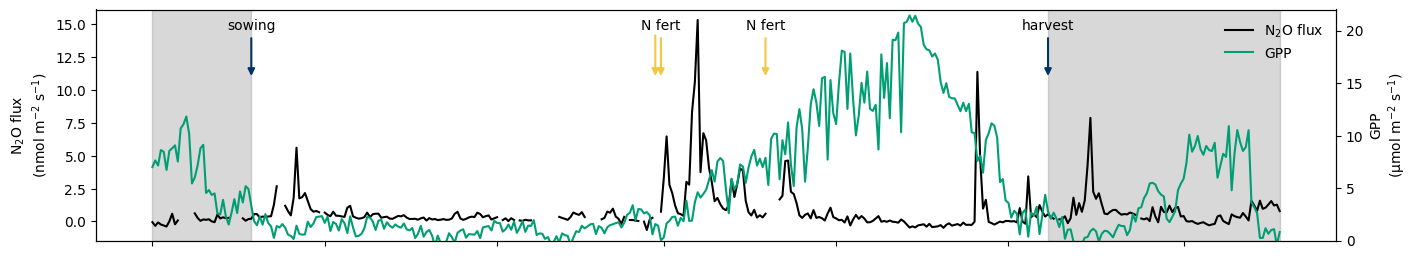

In [20]:
def plot_flux_timeseries(flux_1, flux_2, linestyle='-', linewidth=3,
                         figsize=(12, 4), ax=None, scale_gpp=1/2):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Primary y-axis: N2O
    ax.plot(flux_1.index, flux_1.values, color='black', linestyle=linestyle,
            alpha=1, linewidth=linewidth, label='N$_2$O flux')

    # Secondary y-axis: GPP
    ax2 = ax.twinx()

    # Plot rescaled GPP data
    ax2.plot(flux_2.index, flux_2.values * scale_gpp, color='#009E73', linestyle=linestyle,
             alpha=1, linewidth=linewidth, label='GPP')
    
    # Set ticks for GPP
    true_ticks = np.arange(0, 21, 5)
    ax2.set_yticks(true_ticks * scale_gpp)            # positions (scaled)
    ax2.set_yticklabels([str(t) for t in true_ticks]) # real values
    ax2.set_ylim(0 * scale_gpp, 22 * scale_gpp)       # lock axis
    ax2.set_ylabel("GPP\n(µmol m$^{-2}$ s$^{-1}$)")

    # Annotate management events
    for event in event_lines:
        event_date = pd.to_datetime(event['date'])
        ax.annotate(
            text=event['label'],
            xy=(mdates.date2num(event_date), 0.7),
            xytext=(mdates.date2num(event_date), 0.9),
            xycoords=('data', 'axes fraction'),
            textcoords=('data', 'axes fraction'),
            ha='center',
            va='bottom',
            color='black',
            arrowprops=dict(
                arrowstyle='-|>',
                color=event['color'],
 #               linestyle=event['linestyle'],
                lw=1.5
            ),
            annotation_clip=False
        )

    # Add shading to highlight a certain time window
    ax.axvspan('2022-09-01', highlight_start, color='gray', alpha=0.3, zorder=0)
    ax.axvspan(highlight_end, flux_1.index.max(), color='gray', alpha=0.3, zorder=0)

    # Labels and legends
    ax.set_ylabel("N$_2$O flux\n(nmol m$^{-2}$ s$^{-1}$)")
    ax.tick_params(axis='x', bottom=True, labelbottom=False)

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

    return ax

fig, ax = plt.subplots(figsize=(16, 3))
# Plot normalized SHAP
plot_flux_timeseries(fn2o_agg, gpp_agg, ax=ax, linewidth=1.5)
plt.show()

#### normalized

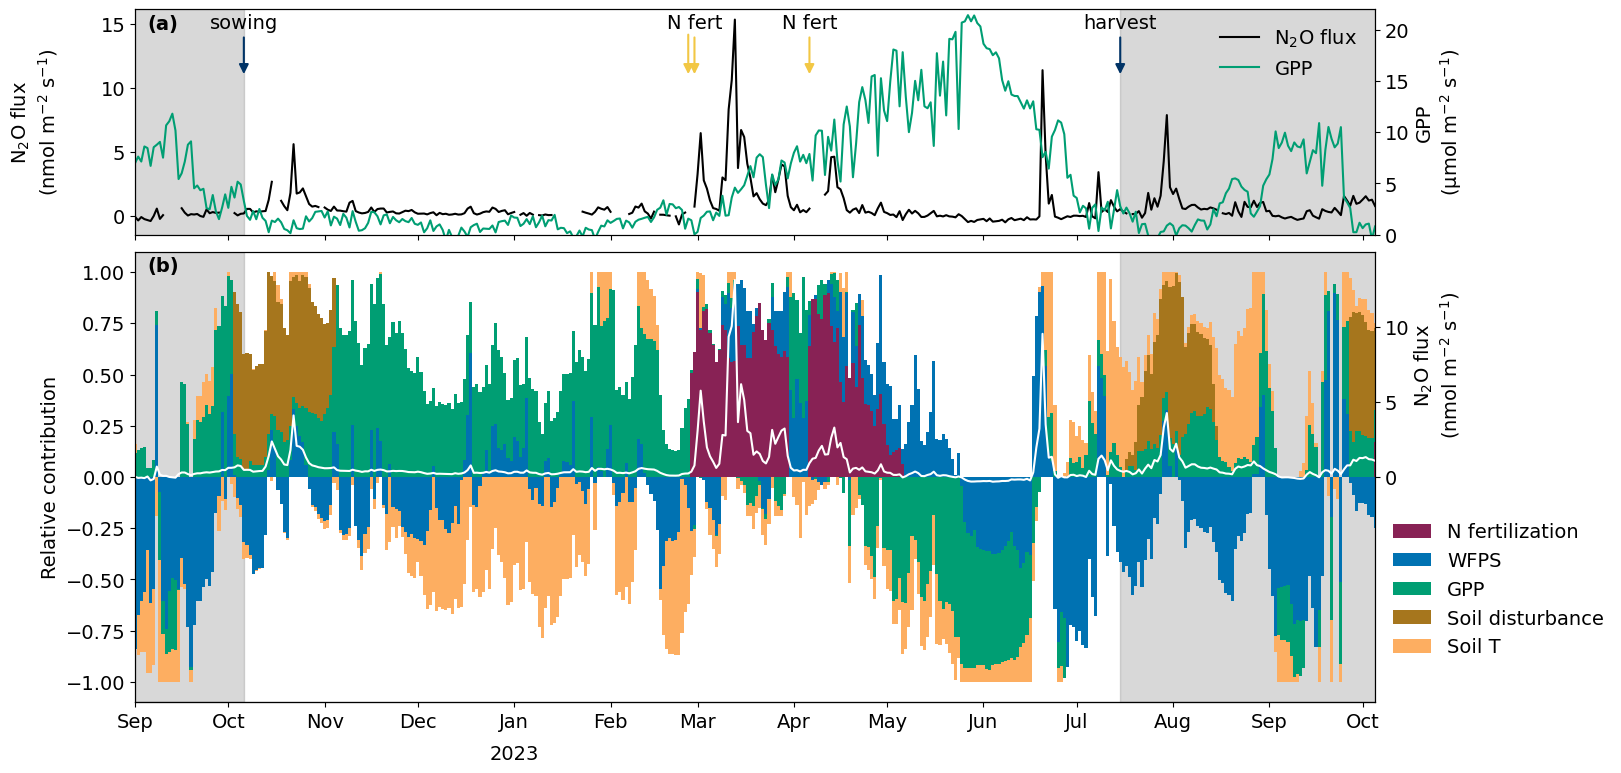

In [21]:
# Plot
plt.rcParams.update({'font.size': 14})  # Set global font size to 12 pt
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 2], hspace=0.05, wspace=0.05)
# Create subplots
ax_flux = fig.add_subplot(gs[0])    # Add subplot label 
ax_shap = fig.add_subplot(gs[1], sharex=ax_flux)
# Add letters to subplots
ax_flux.text(0.01, 0.98, '(a)', transform=ax_flux.transAxes, fontweight='bold', verticalalignment='top')
ax_shap.text(0.01, 0.99, '(b)', transform=ax_shap.transAxes, fontweight='bold', verticalalignment='top')
# Call plotting functions
plot_flux_timeseries(fn2o_agg, gpp_agg, ax=ax_flux, linewidth=1.5)
plot_shap_timeseries(df=shap_df_agg_norm, fn2o_predicted=fn2o_preds_agg, ax1=ax_shap, width=1)
# Align y-axis labels
fig.align_ylabels(fig.axes)
# save fig
plt.savefig('../figures/shap_stacked_bar_normalized.png', dpi=300, bbox_inches="tight")
plt.show()

#### standard

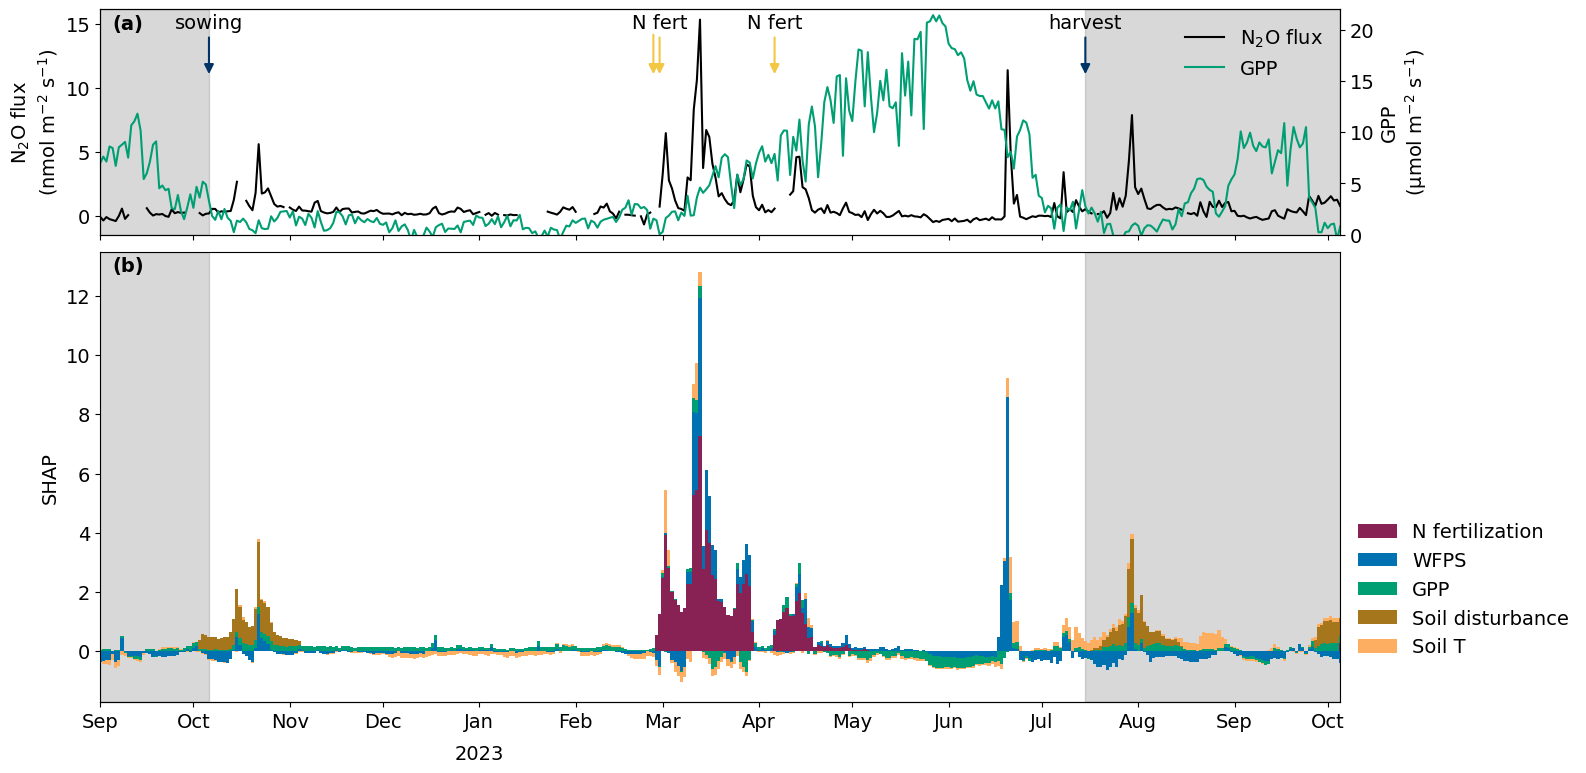

In [22]:
# Plot
plt.rcParams.update({'font.size': 14})  # Set global font size to 12 pt
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 2], hspace=0.05, wspace=0.05)
# Create subplots
ax_flux = fig.add_subplot(gs[0])
ax_shap = fig.add_subplot(gs[1], sharex=ax_flux)
# Add letters to subplots
ax_flux.text(0.01, 0.98, '(a)', transform=ax_flux.transAxes, fontweight='bold', verticalalignment='top')
ax_shap.text(0.01, 0.99, '(b)', transform=ax_shap.transAxes, fontweight='bold', verticalalignment='top')
# Call plotting functions
plot_flux_timeseries(fn2o_agg, gpp_agg, ax=ax_flux, linewidth=1.5)
plot_shap_timeseries(df=shap_df_agg, ax1=ax_shap, width=1)
# Allow autoscale for y axis to show the full range
ax_shap.autoscale(axis='y')
# Rename y axis title
ax_shap.set_ylabel("SHAP")
# Align y-axis labels
fig.align_ylabels(fig.axes)
# save fig
plt.savefig('../figures/shap_stacked_bar_standard.png', dpi=300, bbox_inches="tight")
plt.show()

### Heatmap plot

#### plotting functions

In [23]:
def plot_shap_heatmap(shap_df, cmap='coolwarm', figsize=(16, 6), label='Relative contribution', ax=None, cax=None):

    shap_df = shap_df.copy()
    shap_df = shap_df[shap_df.columns[::-1]]  # reverse feature columns to have in the plot the most important on top
    dates = shap_df.index
    features = shap_df.columns
    data = shap_df.T.values 
    date_nums = mdates.date2num(dates)

    # Create mesh grid for pcolormesh (1 extra on each side)
    X, Y = np.meshgrid(
        np.append(date_nums, date_nums[-1] + 1),
        np.arange(len(features) + 1)
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    pcm = ax.pcolormesh(X, Y, data, cmap=cmap, shading='auto',
                        vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
    
    ax.set_yticks(np.arange(len(features)) + 0.5)
    ax.set_yticklabels(features)
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    secax = ax.secondary_xaxis('bottom')
    secax.xaxis.set_major_locator(mdates.YearLocator())
    secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    secax.tick_params(axis='x', length=0, pad=30)
    
    if cax is not None:
        fig.colorbar(pcm, cax=cax, label=label)
    else:
        fig.colorbar(pcm, ax=ax, label=label)

    return ax

#ax = plot_shap_heatmap(shap_df_norm)

#### normalized

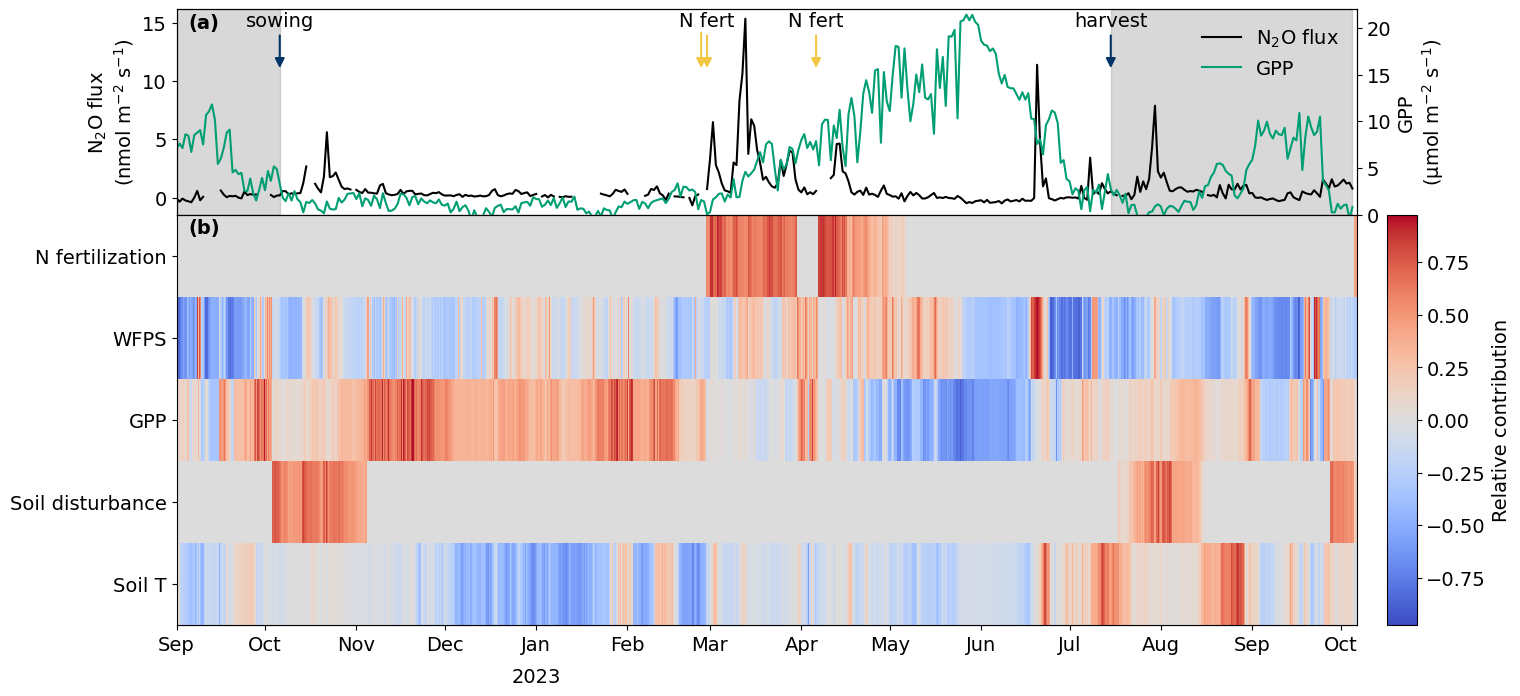

In [24]:
# Create figure with 2 rows, 2 columns (second column for SHAP colorbar)
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[20, 0.5], height_ratios=[1, 2], hspace=0, wspace=0.05)

# Create subplots
ax_flux = fig.add_subplot(gs[0, 0])
ax_shap = fig.add_subplot(gs[1, 0], sharex=ax_flux)
cax = fig.add_subplot(gs[1, 1])  # colorbar axis for SHAP

# Add letters to subplots
ax_flux.text(0.01, 0.98, '(a)', transform=ax_flux.transAxes, fontweight='bold', verticalalignment='top')
ax_shap.text(0.01, 0.99, '(b)', transform=ax_shap.transAxes, fontweight='bold', verticalalignment='top')

# Call your functions
plot_flux_timeseries(fn2o_agg, gpp_agg, ax=ax_flux, linewidth=1.5)
plot_shap_heatmap(shap_df_norm, ax=ax_shap, cax=cax)
plt.show()

#### standard

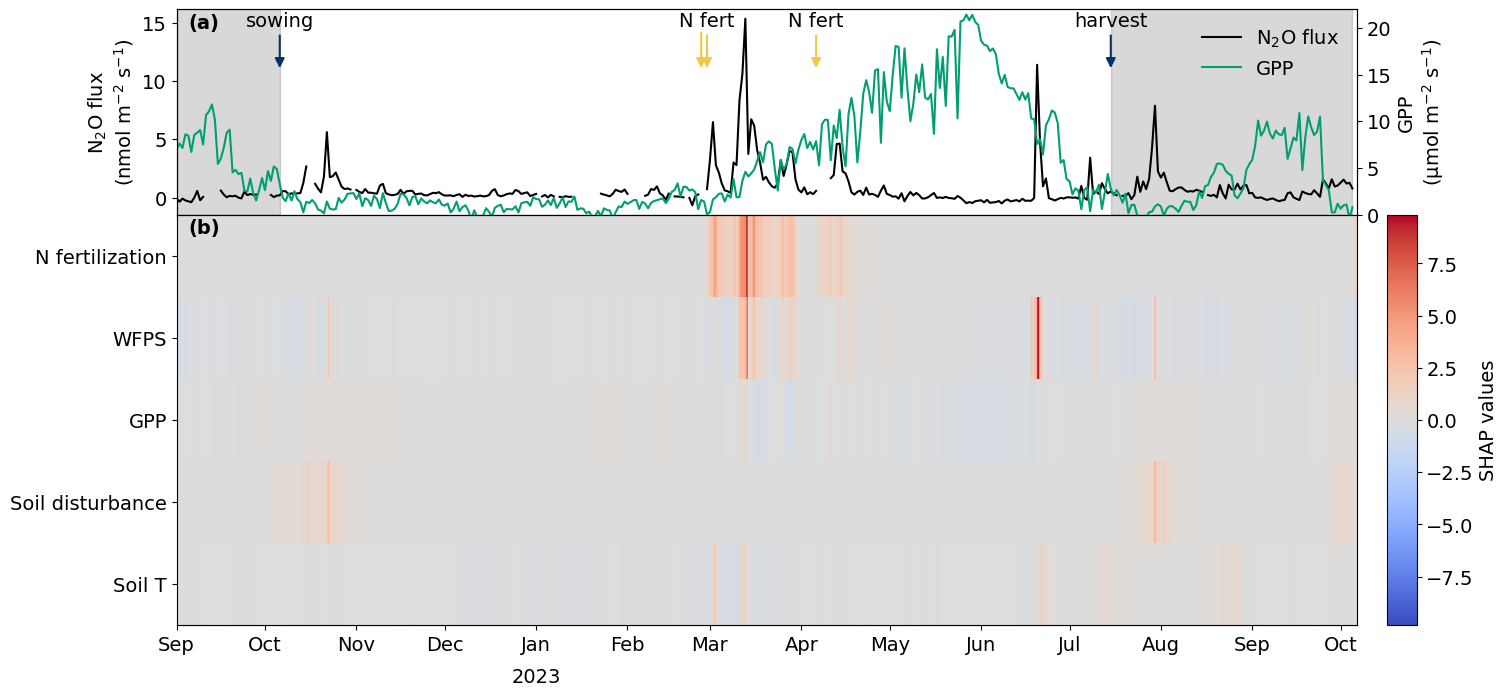

In [25]:
# Create figure with 2 rows, 2 columns (second column for SHAP colorbar)
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[20, 0.5], height_ratios=[1, 2], hspace=0, wspace=0.05)

# Create subplots
ax_flux = fig.add_subplot(gs[0, 0])
ax_shap = fig.add_subplot(gs[1, 0], sharex=ax_flux)
cax = fig.add_subplot(gs[1, 1])  # colorbar axis for SHAP

# Add letters to subplots
ax_flux.text(0.01, 0.98, '(a)', transform=ax_flux.transAxes, fontweight='bold', verticalalignment='top')
ax_shap.text(0.01, 0.99, '(b)', transform=ax_shap.transAxes, fontweight='bold', verticalalignment='top')

# Call your functions
plot_flux_timeseries(fn2o_agg, gpp_agg, ax=ax_flux, linewidth=1.5)
plot_shap_heatmap(shap_df, ax=ax_shap, cax=cax, label='SHAP values')
plt.show()

## OVERALL CONTRIBUTIONS
Total contribution of each driver across the period, separate for positive and negative contributions

In [26]:
positive_contribution = (shap_df[shap_df > 0].sum() / shap_df[shap_df > 0].sum().sum()) * 100
negative_contribution = (shap_df[shap_df < 0].abs().sum() / shap_df[shap_df < 0].abs().sum().sum()) * 100
print('% positive contribution')
print(positive_contribution)
print()
print('% negative contribution')
print(negative_contribution)

% positive contribution
N fertilization     36.609805
WFPS                22.213042
GPP                 14.846675
Soil disturbance    16.481734
Soil T               9.848743
dtype: float64

% negative contribution
N fertilization      0.000000
WFPS                50.101543
GPP                 23.475215
Soil disturbance     0.030024
Soil T              26.393218
dtype: float64


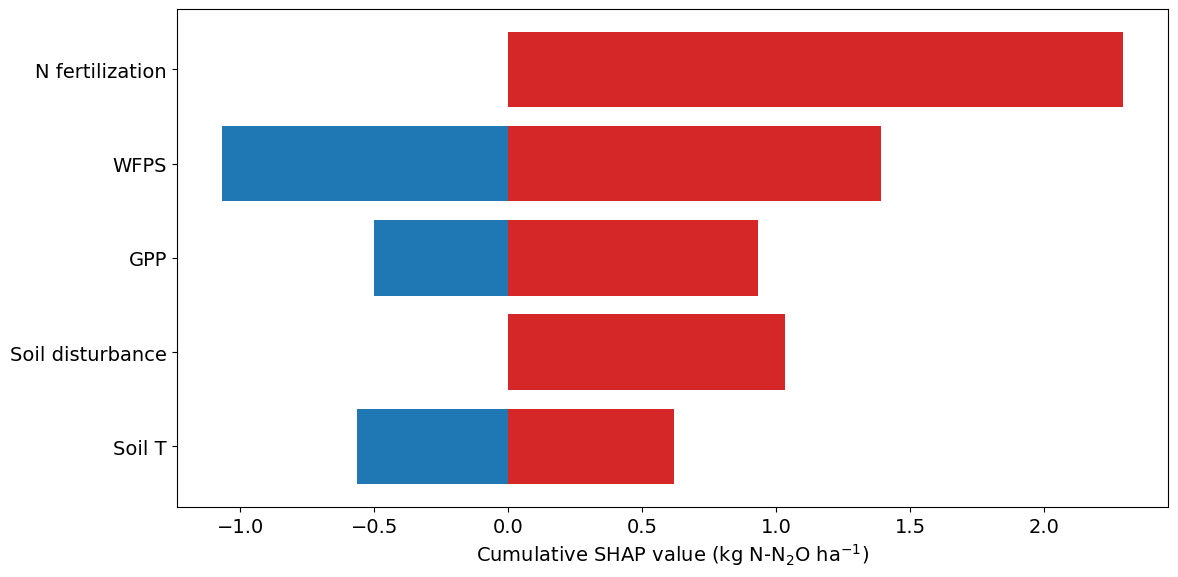

In [27]:
# Get cumulative sums

pos_sum = shap_df[shap_df > 0].sum()
neg_sum = shap_df[shap_df < 0].sum()

# Convert units
pos_sum = pos_sum * 60 * 60 * float(TIME_RESOLUTION) * 28.014 * 1e-9 * 1e-3 * 1e4 # nmol N2O m-2 s-1 → kg N2O-N ha-1 per averaging period (e.g., 4 hours)
neg_sum = neg_sum * 60 * 60 * float(TIME_RESOLUTION) * 28.014 * 1e-9 * 1e-3 * 1e4 # nmol N2O m-2 s-1 → kg N2O-N ha-1 per averaging period (e.g., 4 hours)

# Combine for plotting
contrib_df = pd.concat([pos_sum.rename('Positive'), neg_sum.rename('Negative')], axis=1).fillna(0)

# Plot mirrored bars
plt.rcParams.update({'font.size': 14})  # Set global font size
fig, ax = plt.subplots(figsize=(12, 6))
features = contrib_df.index
ax.barh(features, contrib_df['Negative'], color='#1f77b4')
ax.barh(features, contrib_df['Positive'], color='#d62728')
ax.invert_yaxis() # Reverse y-axis to have the highest positive contributions on top
ax.set_xlabel("Cumulative SHAP value (kg N-N$_{2}$O ha$^{-1}$)")
plt.tight_layout()
# save fig
plt.savefig('../figures/shap_contributions_summary.png', dpi=300, bbox_inches="tight")
plt.show()

## SHAP SCATTERPLOTS

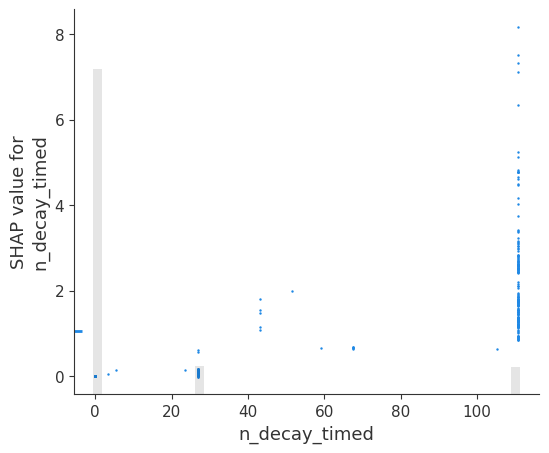

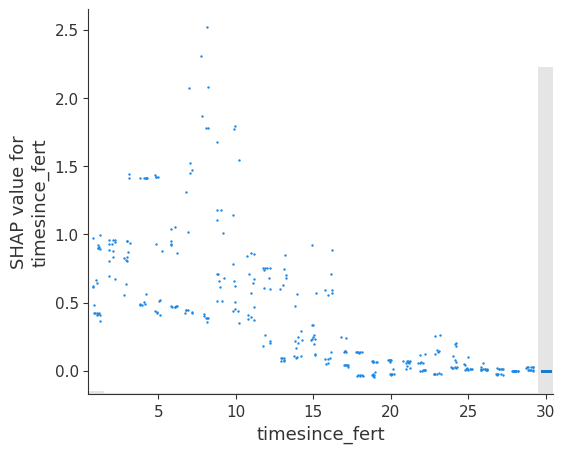

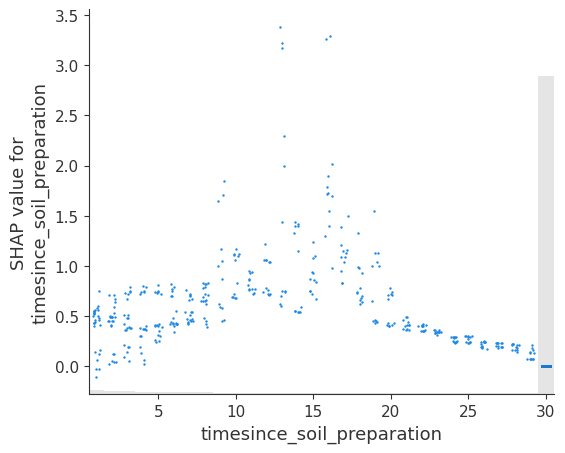

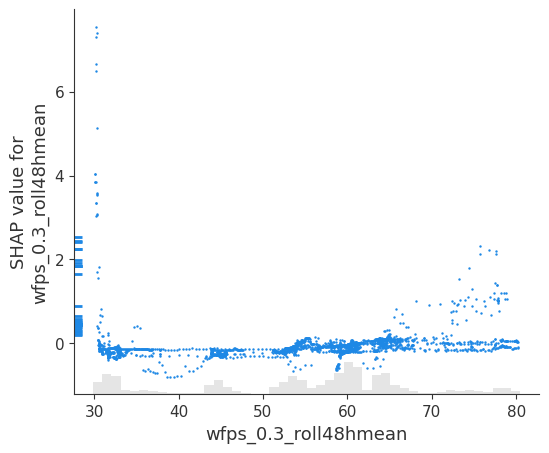

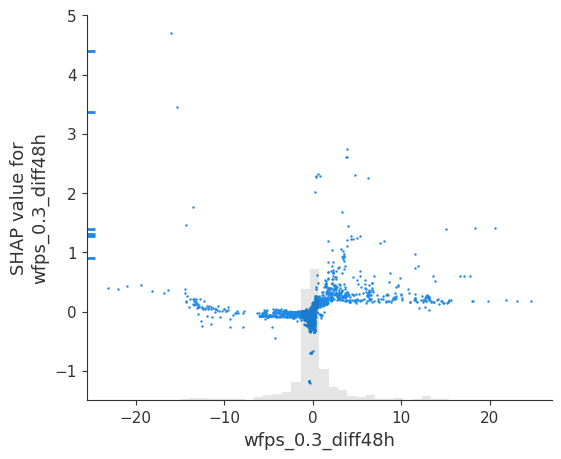

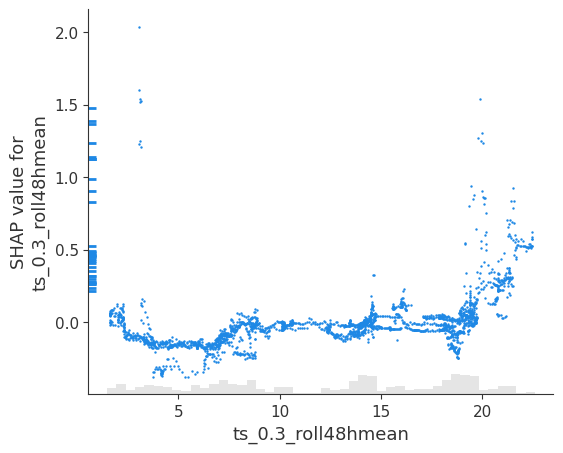

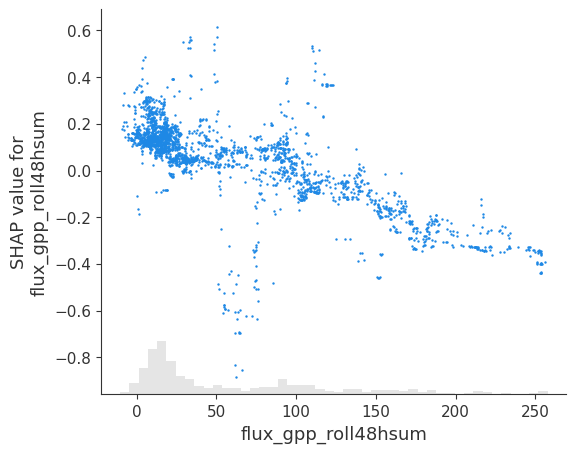

In [28]:
# Dependence plots
for var in X.columns:
    shap.plots.scatter(shap_values[:, var], dot_size=3, x_jitter=0.5)
#    shap.dependence_plot(var, shap_values.values, X)
    plt.show()